# # Gesture Recognition EDA (Exploratory Data Analysis)
# 
# This notebook performs comprehensive exploratory data analysis on accelerometer and gyroscope sensor data for gesture recognition.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from scipy import stats
from scipy.signal import welch
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")

In [10]:
# ====== Step 1: Load and combine all gesture data ======
base_dir = "data"  # top-level data directory
all_data = []

import os

if not os.path.exists('data'):
    os.makedirs('data')

for gesture in os.listdir(base_dir):
    gesture_path = os.path.join(base_dir, gesture)
    if not os.path.isdir(gesture_path):
        continue  # skip non-directories

    for file in os.listdir(gesture_path):
        if file.endswith(".csv"):
            file_path = os.path.join(gesture_path, file)
            df = pd.read_csv(file_path, names=["acx", "acy", "acz", "gyx", "gyy", "gyz"])
            # remove first and last row. There are decent chances these 2 lines are gibberish or missing data.
            df = df.iloc[1:-1].reset_index(drop=True)
            df["label"] = gesture  # add gesture label column
            df["file_id"] = file  # track which file this data came from
            all_data.append(df)

# Merge all into one DataFrame
data = pd.concat(all_data, ignore_index=True)


In [11]:
# Ensure numeric dtype for sensor columns
for col in ["acx", "acy", "acz", "gyx", "gyy", "gyz"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

print("Data shape:", data.shape)
print("\nGesture distribution:")
print(data["label"].value_counts())
print("\nFirst few rows:")
print(data.head())

Data shape: (22124, 8)

Gesture distribution:
label
rear_hook        7674
idle_noise       7387
rear_uppercut    5238
wave             1825
Name: count, dtype: int64

First few rows:
     acx   acy   acz   gyx  gyy   gyz       label             file_id
0  10.32  0.02 -1.03 -0.01 -0.0 -0.01  idle_noise  idle_noise_001.csv
1  10.28  0.09 -0.98 -0.01 -0.0 -0.01  idle_noise  idle_noise_001.csv
2  10.30  0.04 -1.00 -0.01 -0.0 -0.01  idle_noise  idle_noise_001.csv
3  10.43 -0.09 -1.00 -0.01 -0.0 -0.01  idle_noise  idle_noise_001.csv
4  10.24 -0.02 -0.97 -0.01 -0.0 -0.01  idle_noise  idle_noise_001.csv


In [12]:
# ====== Basic Data Information ======
print("=== DATASET OVERVIEW ===")
print(f"Total samples: {len(data):,}")
print(f"Number of gestures: {data['label'].nunique()}")
print(f"Gesture types: {list(data['label'].unique())}")
print(f"Number of files: {data['file_id'].nunique()}")

print("\n=== MISSING VALUES ===")
print(data.isnull().sum())

print("\n=== BASIC STATISTICS ===")
print(data.describe())



=== DATASET OVERVIEW ===
Total samples: 22,124
Number of gestures: 4
Gesture types: ['idle_noise', 'rear_hook', 'rear_uppercut', 'wave']
Number of files: 9

=== MISSING VALUES ===
acx        0
acy        0
acz        0
gyx        0
gyy        0
gyz        0
label      0
file_id    0
dtype: int64

=== BASIC STATISTICS ===
                acx           acy           acz           gyx           gyy  \
count  22124.000000  22124.000000  22124.000000  22124.000000  22124.000000   
mean       1.678072      2.632846      0.427066     -0.168437      0.119041   
std       18.509151     13.610645     10.410122      5.127064      2.251120   
min      -57.800000    -22.190000    -78.450000    -34.870000    -23.130000   
25%       -3.740000     -6.110000     -5.500000     -1.150000     -0.470000   
50%        2.760000     -0.650000      0.390000     -0.030000      0.030000   
75%       10.290000      6.170000      6.350000      0.590000      0.820000   
max      100.820000    156.900000     58.5800

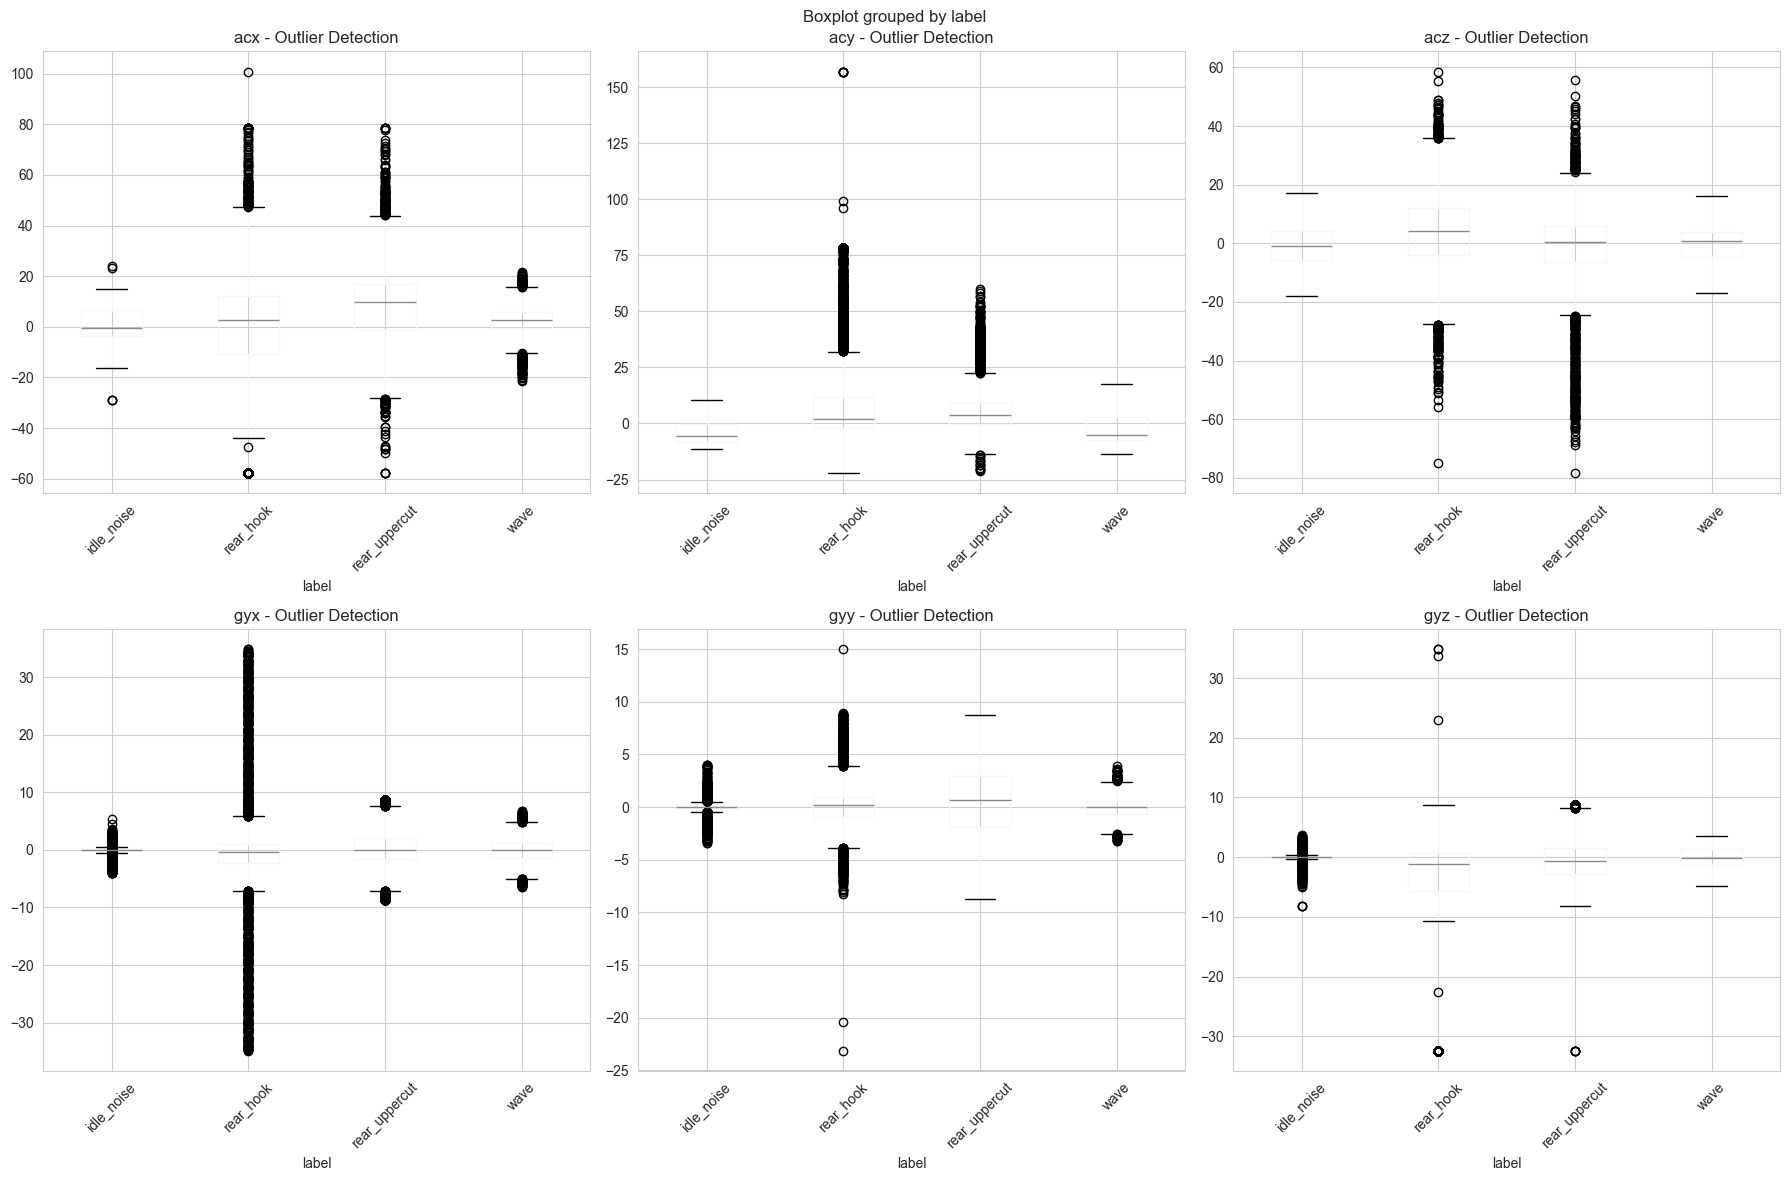

In [13]:
# ====== Enhanced Data Quality Analysis ======
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Data Quality Assessment: Missing Values and Outliers', fontsize=16)

# Check for missing values per column
sensor_cols = ["acx", "acy", "acz", "gyx", "gyy", "gyz"]
for i, col in enumerate(sensor_cols):
    row, col_idx = i // 3, i % 3
    
    # Box plot to identify outliers
    data.boxplot(column=col, by='label', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} - Outlier Detection')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

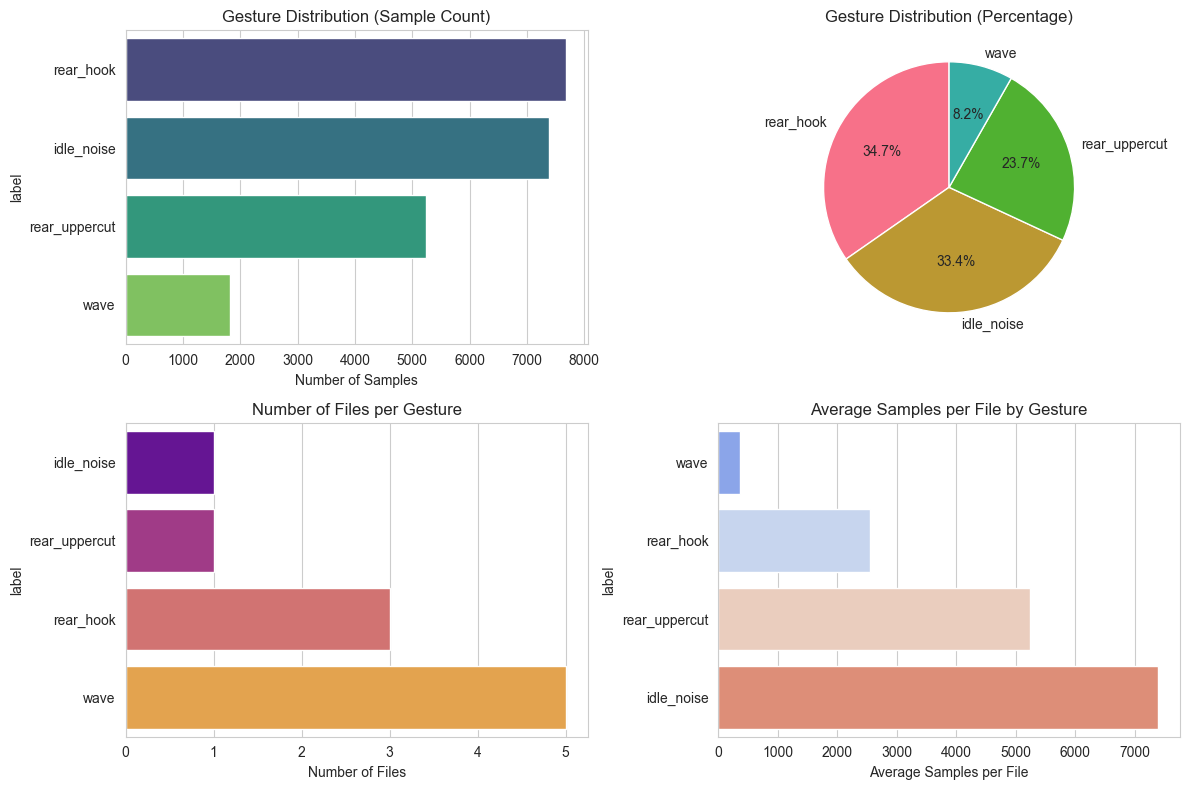

In [14]:
# ====== Gesture Distribution Analysis ======
plt.figure(figsize=(12, 8))

# Gesture count distribution
plt.subplot(2, 2, 1)
gesture_counts = data['label'].value_counts()
sns.barplot(x=gesture_counts.values, y=gesture_counts.index, palette='viridis')
plt.title('Gesture Distribution (Sample Count)')
plt.xlabel('Number of Samples')

# Gesture distribution pie chart
plt.subplot(2, 2, 2)
plt.pie(gesture_counts.values, labels=gesture_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gesture Distribution (Percentage)')

# Files per gesture
plt.subplot(2, 2, 3)
files_per_gesture = data.groupby('label')['file_id'].nunique().sort_values(ascending=True)
sns.barplot(x=files_per_gesture.values, y=files_per_gesture.index, palette='plasma')
plt.title('Number of Files per Gesture')
plt.xlabel('Number of Files')

# Average samples per file by gesture
plt.subplot(2, 2, 4)
avg_samples = data.groupby(['label', 'file_id']).size().groupby('label').mean().sort_values(ascending=True)
sns.barplot(x=avg_samples.values, y=avg_samples.index, palette='coolwarm')
plt.title('Average Samples per File by Gesture')
plt.xlabel('Average Samples per File')

plt.tight_layout()
plt.show()

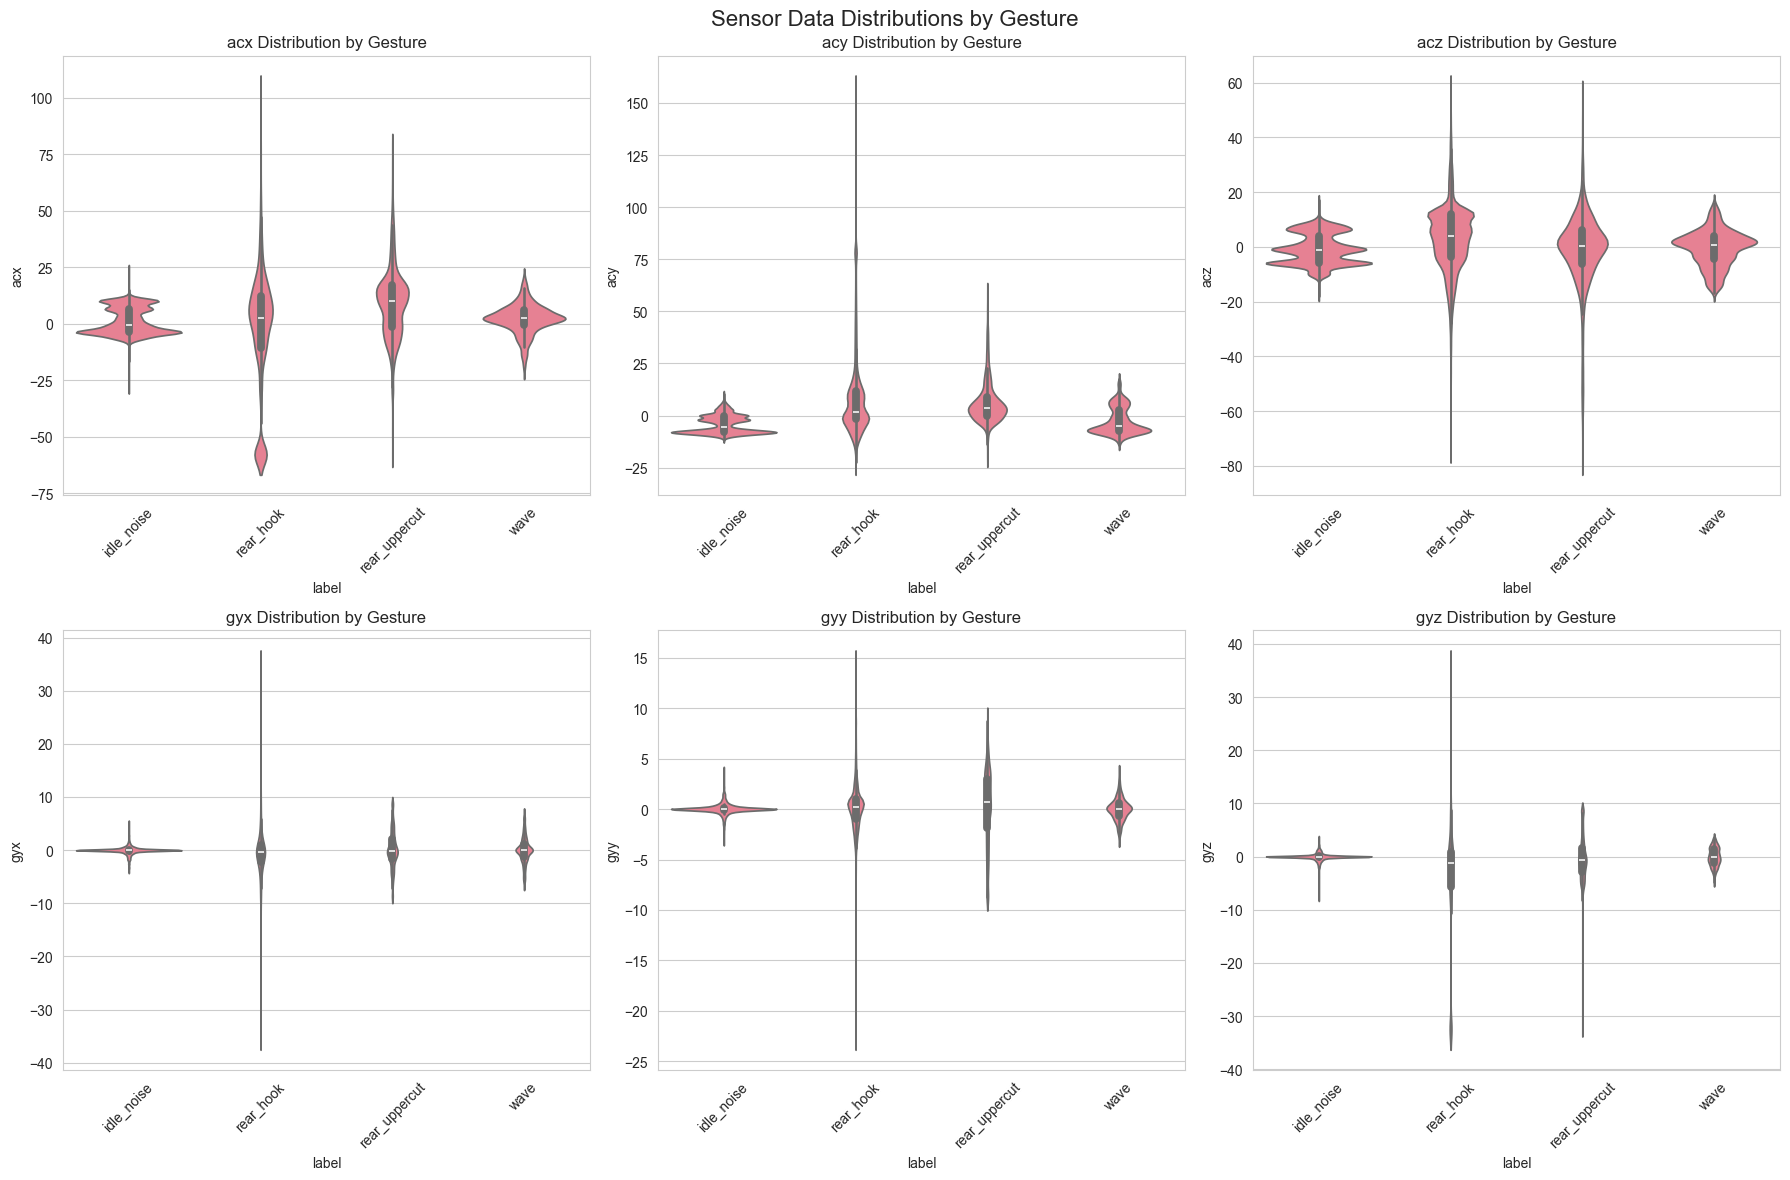

In [15]:
# ====== Sensor Data Distribution Analysis ======
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sensor Data Distributions by Gesture', fontsize=16)

for i, col in enumerate(sensor_cols):
    row, col_idx = i // 3, i % 3
    
    # Distribution plots by gesture
    sns.violinplot(data=data, x='label', y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} Distribution by Gesture')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

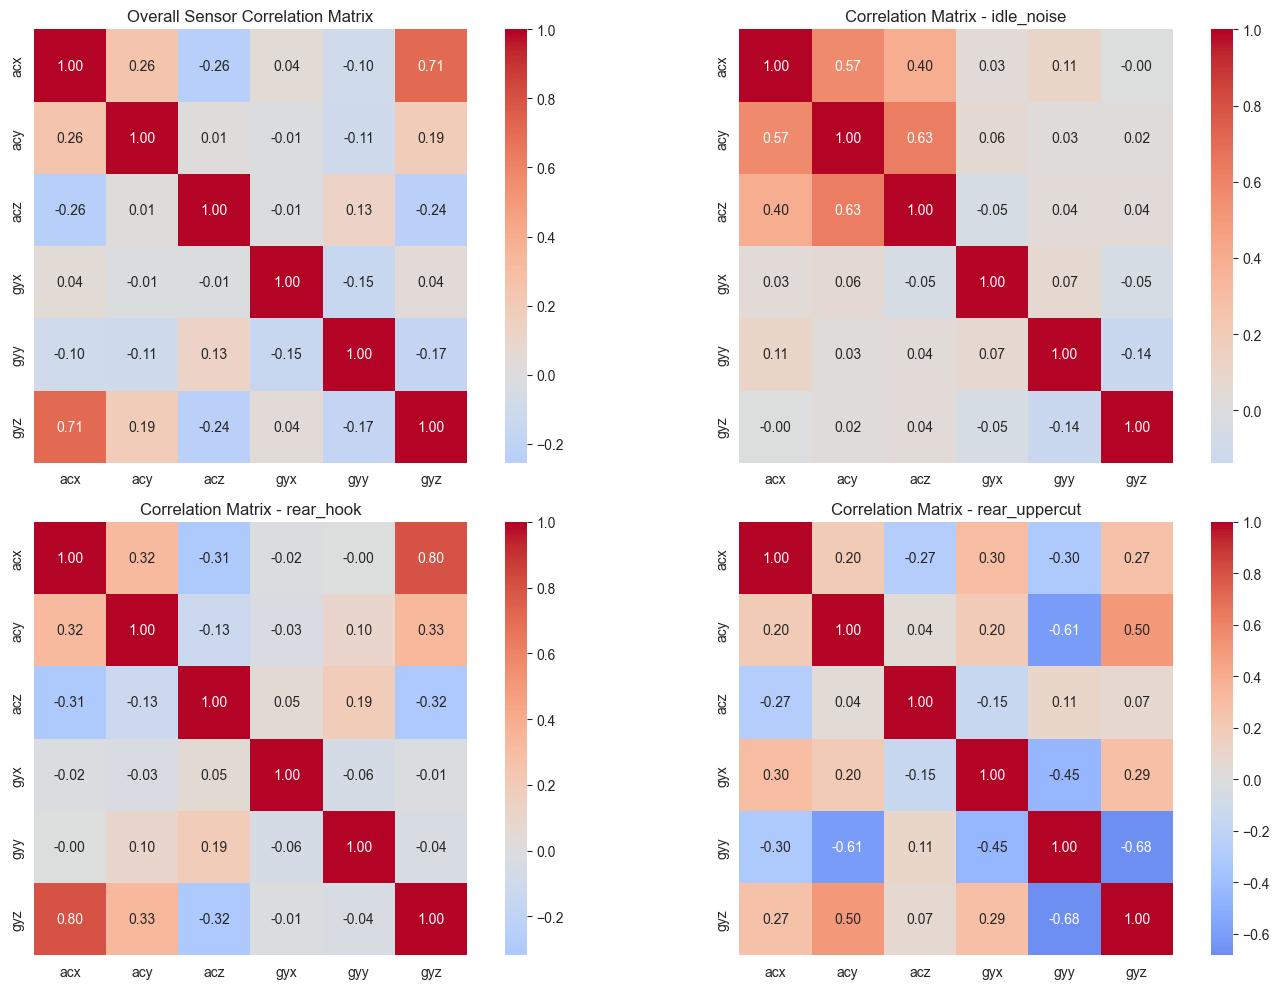

In [16]:
# ====== Correlation Analysis ======
plt.figure(figsize=(15, 10))

# Overall correlation matrix
plt.subplot(2, 2, 1)
corr_matrix = data[sensor_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Overall Sensor Correlation Matrix')

# Correlation by gesture type (example with first 3 gestures)
gestures = data['label'].unique()[:3]
for i, gesture in enumerate(gestures):
    plt.subplot(2, 2, i+2)
    gesture_data = data[data['label'] == gesture]
    gesture_corr = gesture_data[sensor_cols].corr()
    sns.heatmap(gesture_corr, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title(f'Correlation Matrix - {gesture}')

plt.tight_layout()
plt.show()


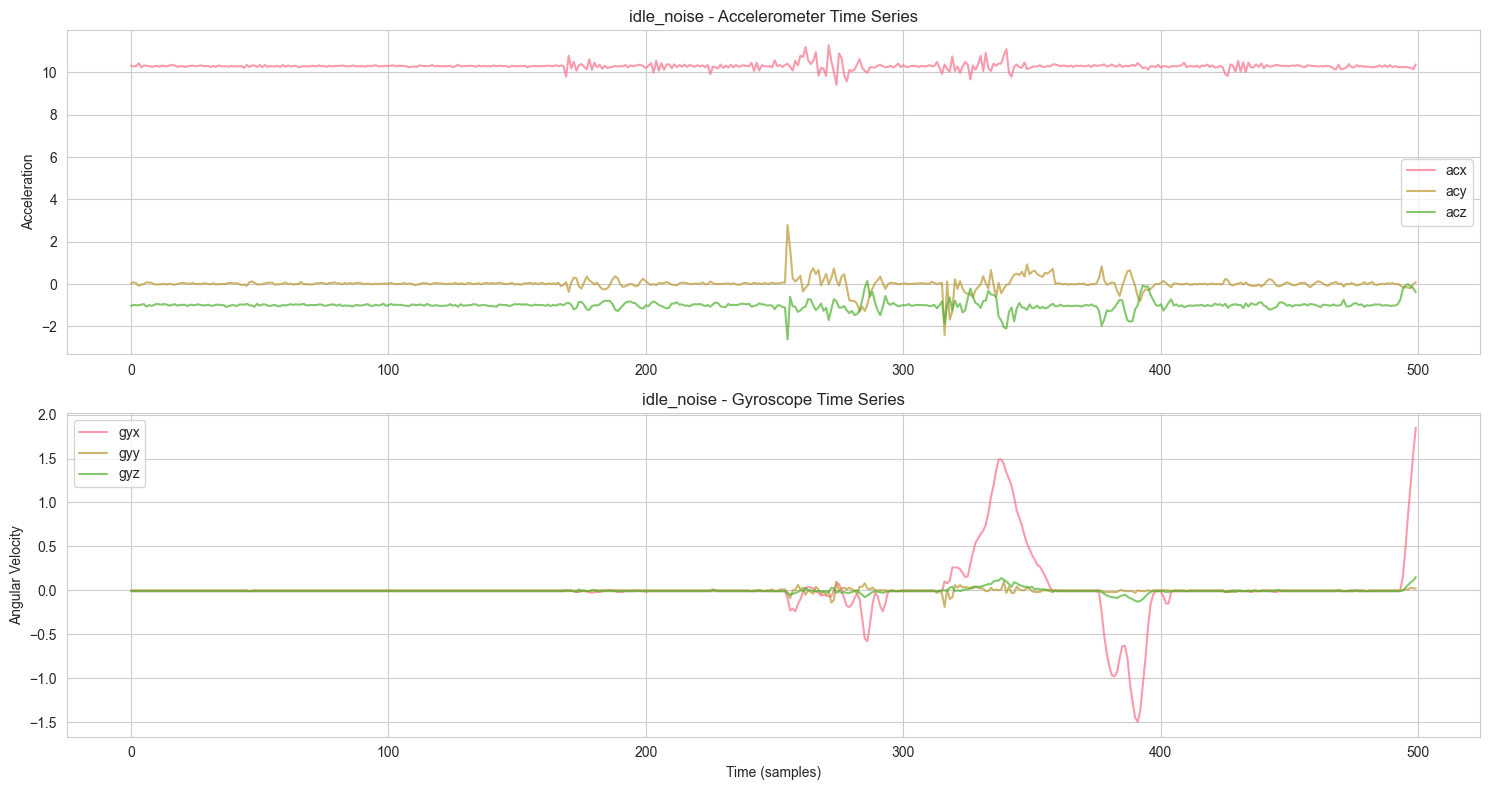

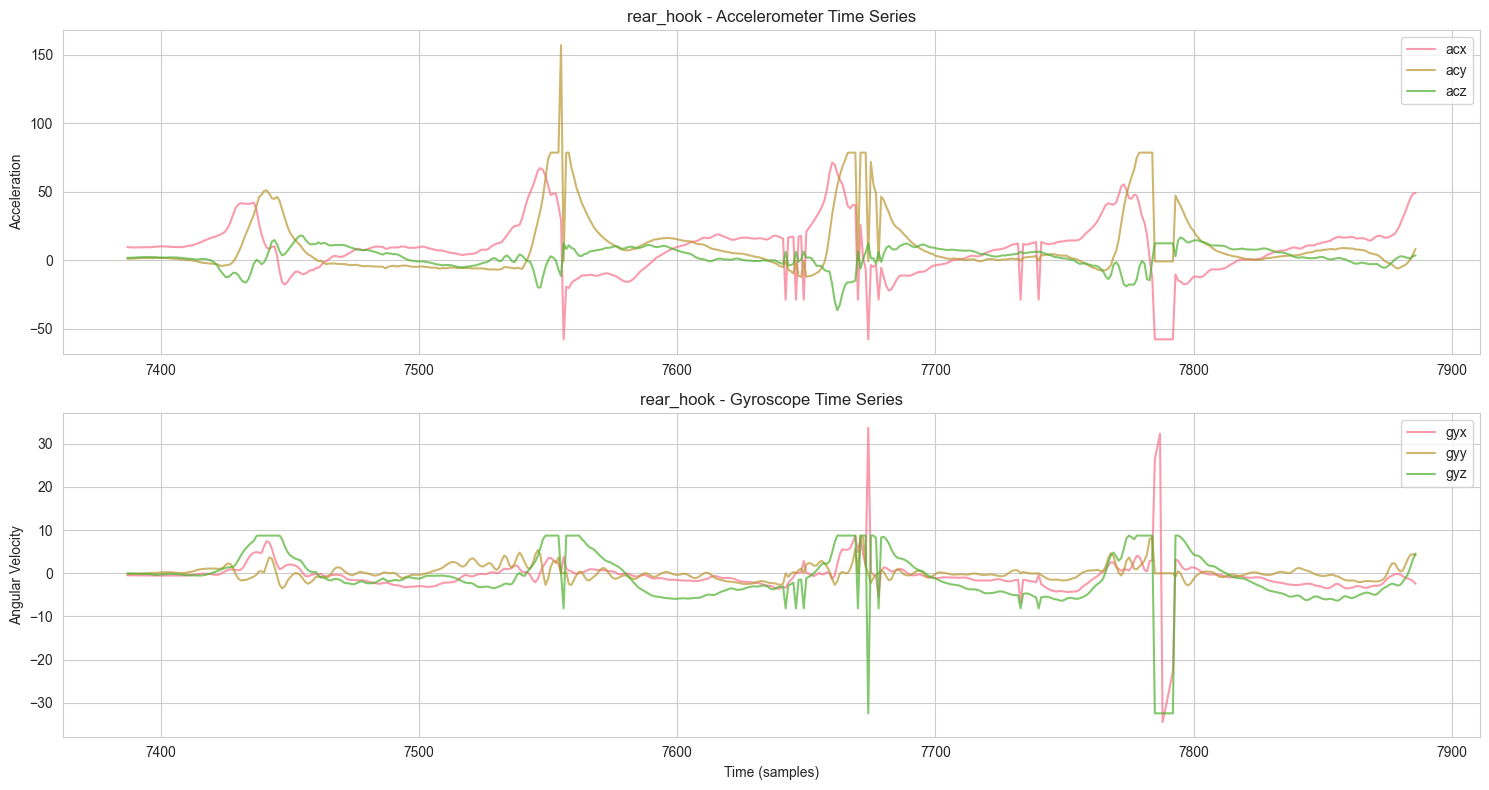

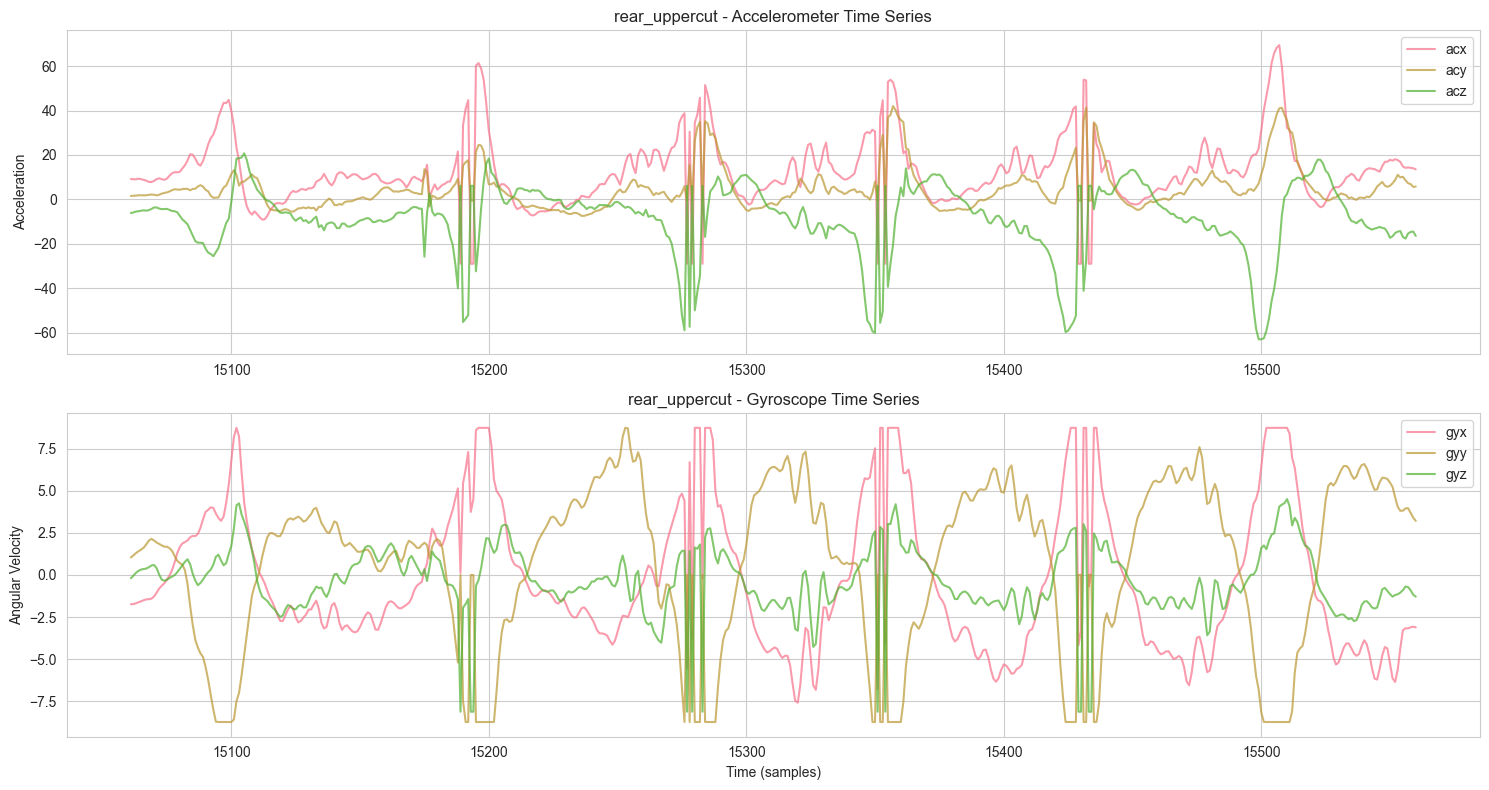

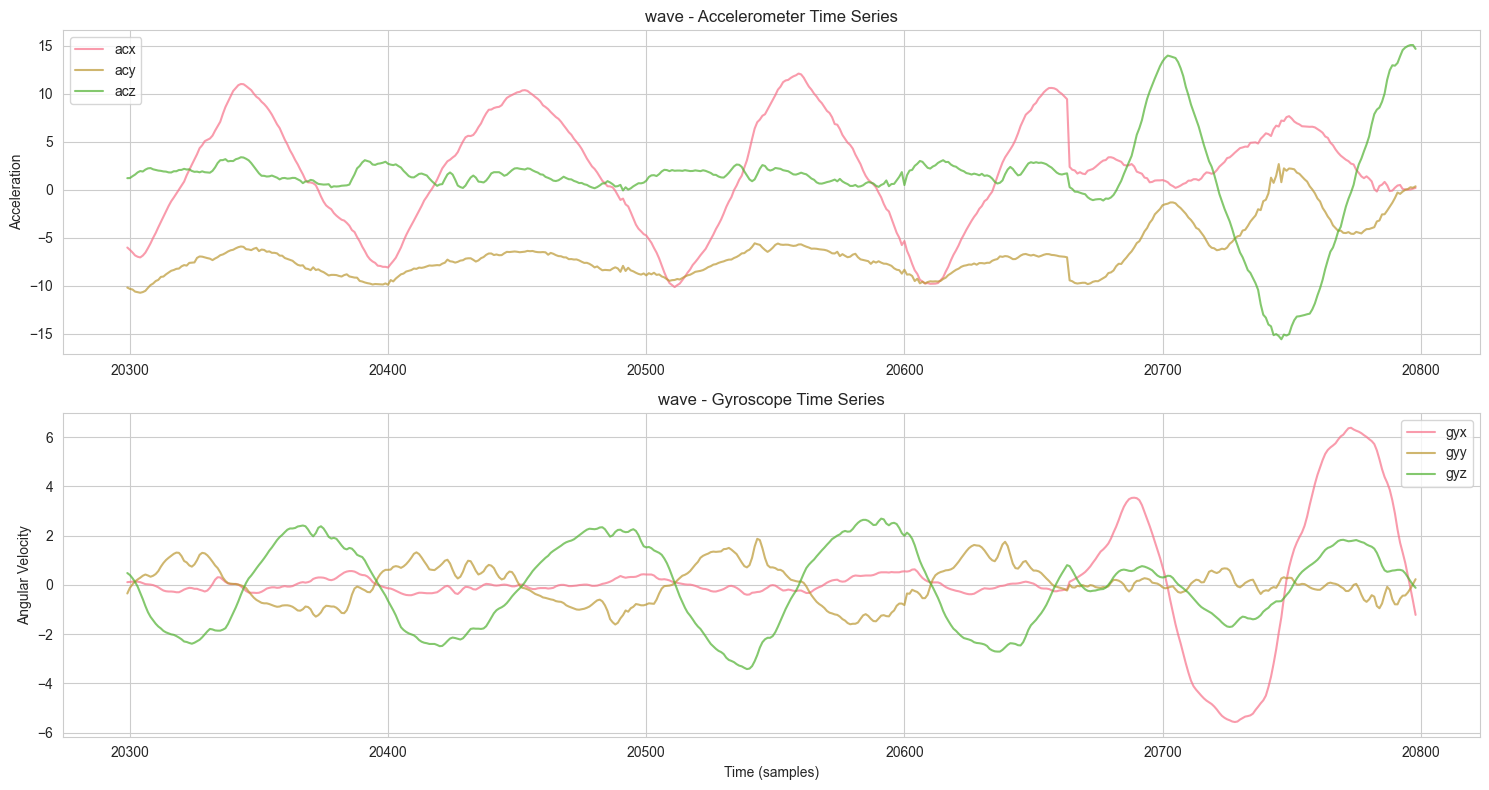

In [17]:
# ====== Time Series Analysis ======
def plot_time_series_sample(gesture, max_samples=500):
    """Plot time series for a sample of each gesture"""
    gesture_data = data[data['label'] == gesture].head(max_samples)
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Accelerometer data
    axes[0].plot(gesture_data['acx'], label='acx', alpha=0.7)
    axes[0].plot(gesture_data['acy'], label='acy', alpha=0.7)
    axes[0].plot(gesture_data['acz'], label='acz', alpha=0.7)
    axes[0].set_title(f'{gesture} - Accelerometer Time Series')
    axes[0].set_ylabel('Acceleration')
    axes[0].legend()
    axes[0].grid(True)
    
    # Gyroscope data
    axes[1].plot(gesture_data['gyx'], label='gyx', alpha=0.7)
    axes[1].plot(gesture_data['gyy'], label='gyy', alpha=0.7)
    axes[1].plot(gesture_data['gyz'], label='gyz', alpha=0.7)
    axes[1].set_title(f'{gesture} - Gyroscope Time Series')
    axes[1].set_xlabel('Time (samples)')
    axes[1].set_ylabel('Angular Velocity')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot time series for each gesture
for gesture in data['label'].unique():
    plot_time_series_sample(gesture)


In [18]:
# ====== Statistical Analysis by Gesture ======
print("=== STATISTICAL ANALYSIS BY GESTURE ===")

# Calculate statistics for each gesture
gesture_stats = []
for gesture in data['label'].unique():
    gesture_data = data[data['label'] == gesture]
    stats_dict = {'gesture': gesture}
    
    for col in sensor_cols:
        stats_dict.update({
            f'{col}_mean': gesture_data[col].mean(),
            f'{col}_std': gesture_data[col].std(),
            f'{col}_range': gesture_data[col].max() - gesture_data[col].min(),
            f'{col}_skew': stats.skew(gesture_data[col]),
            f'{col}_kurtosis': stats.kurtosis(gesture_data[col])
        })
    
    gesture_stats.append(stats_dict)

gesture_stats_df = pd.DataFrame(gesture_stats)
print(gesture_stats_df.round(3))


=== STATISTICAL ANALYSIS BY GESTURE ===
         gesture  acx_mean  acx_std  acx_range  acx_skew  acx_kurtosis  \
0     idle_noise     1.279    5.819      52.95     0.312        -1.026   
1      rear_hook    -3.149   26.903     158.62    -0.748         0.364   
2  rear_uppercut     9.114   15.301     136.25     0.326         1.679   
3           wave     2.248    6.590      43.15    -0.406         1.081   

   acy_mean  acy_std  acy_range  acy_skew  ...  gyy_mean  gyy_std  gyy_range  \
0    -4.213    4.277      21.85     0.502  ...     0.028    0.560       7.41   
1     8.079   18.727     179.09     2.346  ...     0.200    2.189      38.13   
2     6.148    9.853      81.14     1.636  ...     0.175    3.674      17.46   
3    -2.645    6.392      31.07     0.854  ...    -0.012    1.090       7.12   

   gyy_skew  gyy_kurtosis  gyz_mean  gyz_std  gyz_range  gyz_skew  \
0     0.233         9.798    -0.023    0.674      11.77    -1.349   
1     0.313         5.083    -5.213   11.705      

<Figure size 1200x1000 with 0 Axes>

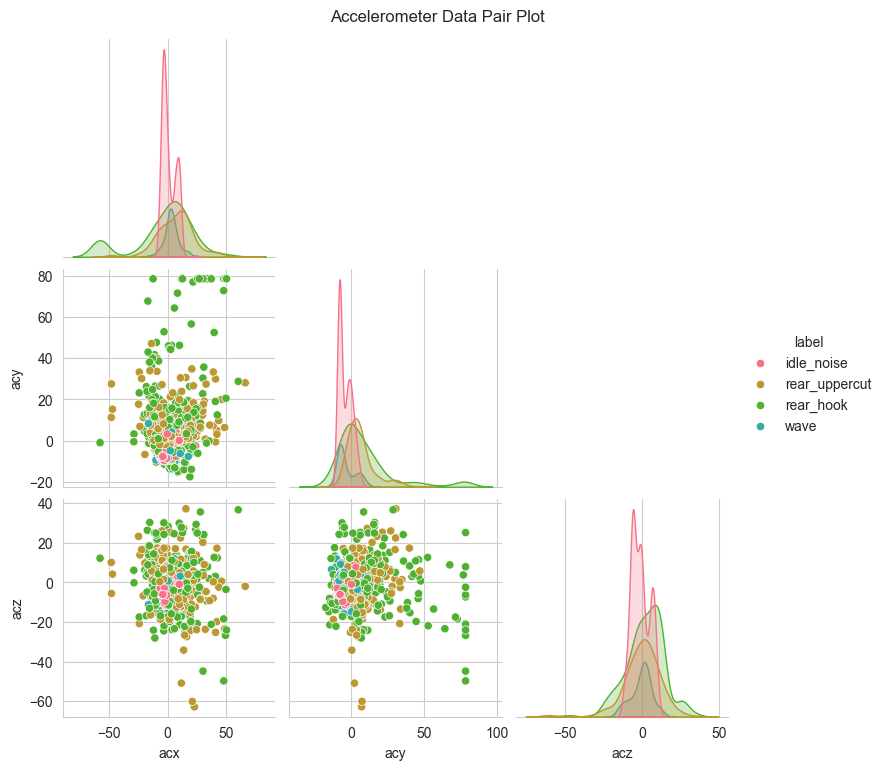

<Figure size 1200x1000 with 0 Axes>

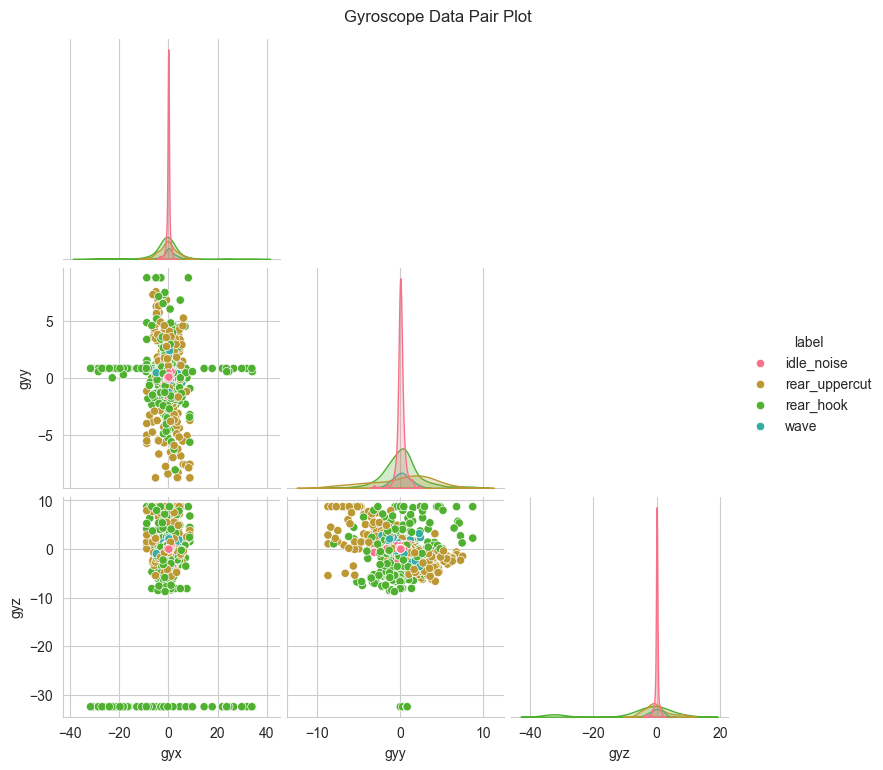

In [19]:
# ====== Advanced Visualization: Pair Plots ======
# Sample data for performance (seaborn pairplot can be slow with large datasets)
sample_size = min(1000, len(data))
data_sample = data.sample(n=sample_size, random_state=42)

# Accelerometer pair plot
plt.figure(figsize=(12, 10))
acc_data = data_sample[['acx', 'acy', 'acz', 'label']]
sns.pairplot(acc_data, hue='label', diag_kind='kde', corner=True)
plt.suptitle('Accelerometer Data Pair Plot', y=1.02)
plt.show()

# Gyroscope pair plot
plt.figure(figsize=(12, 10))
gyro_data = data_sample[['gyx', 'gyy', 'gyz', 'label']]
sns.pairplot(gyro_data, hue='label', diag_kind='kde', corner=True)
plt.suptitle('Gyroscope Data Pair Plot', y=1.02)
plt.show()


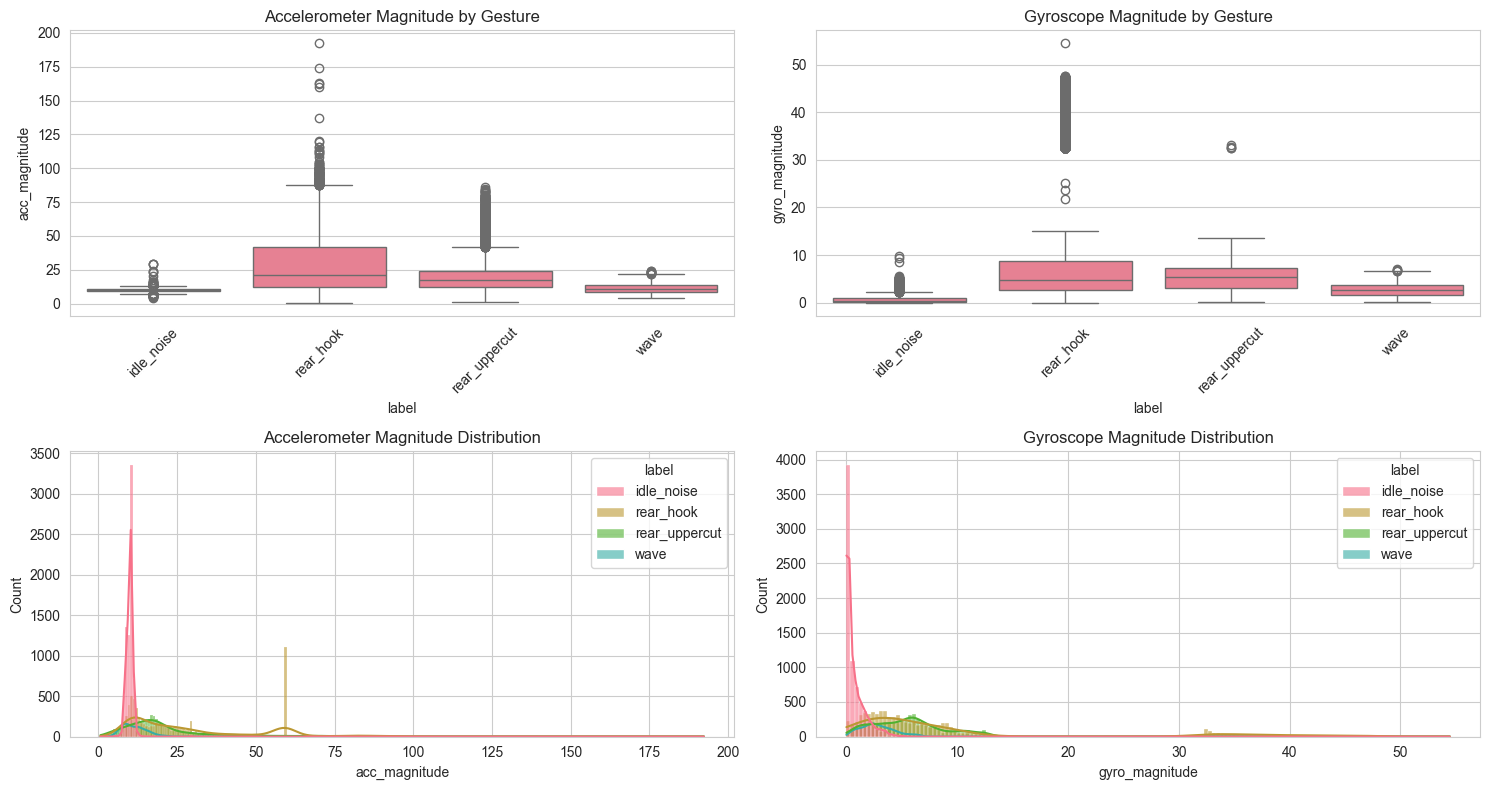

In [20]:
# ====== Magnitude and Derivative Analysis ======
# Calculate magnitude and derivatives for better insights
data['acc_magnitude'] = np.sqrt(data['acx']**2 + data['acy']**2 + data['acz']**2)
data['gyro_magnitude'] = np.sqrt(data['gyx']**2 + data['gyy']**2 + data['gyz']**2)

# Calculate derivatives (rate of change)
data['acc_magnitude_diff'] = data.groupby(['label', 'file_id'])['acc_magnitude'].diff()
data['gyro_magnitude_diff'] = data.groupby(['label', 'file_id'])['gyro_magnitude'].diff()

# Plot magnitude distributions
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=data, x='label', y='acc_magnitude')
plt.title('Accelerometer Magnitude by Gesture')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(data=data, x='label', y='gyro_magnitude')
plt.title('Gyroscope Magnitude by Gesture')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.histplot(data=data, x='acc_magnitude', hue='label', alpha=0.6, kde=True)
plt.title('Accelerometer Magnitude Distribution')

plt.subplot(2, 2, 4)
sns.histplot(data=data, x='gyro_magnitude', hue='label', alpha=0.6, kde=True)
plt.title('Gyroscope Magnitude Distribution')

plt.tight_layout()
plt.show()


In [21]:
# ====== Interactive 3D Visualizations ======
# Enhanced 3D accelerometer scatter
fig = px.scatter_3d(
    data_sample,
    x="acx", y="acy", z="acz",
    color="label",
    opacity=0.6,
    title="3D Accelerometer Scatter (Interactive)",
    labels={'acx': 'Acceleration X', 'acy': 'Acceleration Y', 'acz': 'Acceleration Z'}
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(height=600)
fig.show()

# Enhanced 3D gyroscope scatter
fig = px.scatter_3d(
    data_sample,
    x="gyx", y="gyy", z="gyz",
    color="label",
    opacity=0.6,
    title="3D Gyroscope Scatter (Interactive)",
    labels={'gyx': 'Gyro X', 'gyy': 'Gyro Y', 'gyz': 'Gyro Z'}
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(height=600)
fig.show()


In [22]:
# ====== Frequency Domain Analysis ======
def analyze_frequency_domain(gesture_data, gesture_name, sampling_rate=50):
    """Analyze frequency characteristics of gesture data"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Frequency Domain Analysis - {gesture_name}', fontsize=16)
    
    for i, col in enumerate(sensor_cols):
        row, col_idx = i // 3, i % 3
        
        # Compute power spectral density
        frequencies, psd = welch(gesture_data[col], fs=sampling_rate, nperseg=256)
        
        axes[row, col_idx].semilogy(frequencies, psd)
        axes[row, col_idx].set_title(f'{col} Power Spectral Density')
        axes[row, col_idx].set_xlabel('Frequency (Hz)')
        axes[row, col_idx].set_ylabel('Power/Frequency')
        axes[row, col_idx].grid(True)
    
    plt.tight_layout()
    plt.show()


In [25]:
# # Analyze frequency domain for each gesture (using first 1000 samples)
# for gesture in data['label'].unique():
#     gesture_data = data[data['label'] == gesture].head(1000)
#     if len(gesture_data) > 100:  # Only analyze if we have enough data
#         analyze_frequency_domain(gesture_data, gesture)


ValueError: Could not interpret value `total_acceleration` for `x`. An entry with this name does not appear in `data`.

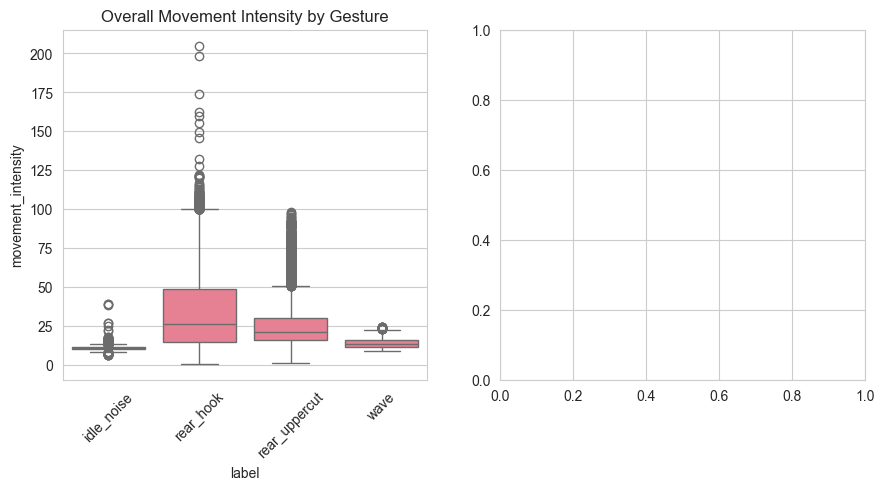

In [26]:
# ====== Movement Intensity Analysis ======
plt.figure(figsize=(16, 10))

# Calculate movement intensity metrics
data['total_acceleration'] = data['acc_magnitude']
data['total_rotation'] = data['gyro_magnitude']
data['movement_intensity'] = data['total_acceleration'] + data['total_rotation']

# Movement intensity by gesture
plt.subplot(2, 3, 1)
sns.boxplot(data=data, x='label', y='movement_intensity')
plt.title('Overall Movement Intensity by Gesture')
plt.xticks(rotation=45)

# Acceleration vs rotation relationship
plt.subplot(2, 3, 2)
sns.scatterplot(data=data_sample, x='total_acceleration', y='total_rotation', hue='label', alpha=0.6)
plt.title('Acceleration vs Rotation Relationship')

# Movement intensity over time (sample)
plt.subplot(2, 3, 3)
for gesture in data['label'].unique():
    gesture_sample = data[data['label'] == gesture].head(200)
    plt.plot(gesture_sample['movement_intensity'].rolling(10).mean(), 
             label=gesture, alpha=0.7)
plt.title('Movement Intensity Over Time (Smoothed)')
plt.xlabel('Time (samples)')
plt.ylabel('Movement Intensity')
plt.legend()

# Range analysis
plt.subplot(2, 3, 4)
range_data = data.groupby('label')[sensor_cols].apply(lambda x: x.max() - x.min()).mean(axis=1)
sns.barplot(x=range_data.values, y=range_data.index, palette='viridis')
plt.title('Average Range Across All Sensors')
plt.xlabel('Average Range')

# Variance analysis
plt.subplot(2, 3, 5)
variance_data = data.groupby('label')[sensor_cols].var().mean(axis=1)
sns.barplot(x=variance_data.values, y=variance_data.index, palette='plasma')
plt.title('Average Variance Across All Sensors')
plt.xlabel('Average Variance')

# Peak detection
plt.subplot(2, 3, 6)
peak_counts = data.groupby('label')['acc_magnitude'].apply(
    lambda x: len([i for i in range(1, len(x)-1) if x.iloc[i] > x.iloc[i-1] and x.iloc[i] > x.iloc[i+1]])
)
sns.barplot(x=peak_counts.values, y=peak_counts.index, palette='coolwarm')
plt.title('Peak Count in Acceleration Magnitude')
plt.xlabel('Number of Peaks')

plt.tight_layout()
plt.show()


In [27]:
# ====== Advanced Statistical Analysis ======
print("=== ADVANCED STATISTICAL ANALYSIS ===")

# Perform ANOVA test to check if gestures have significantly different means
from scipy.stats import f_oneway

print("F-statistic and p-values for ANOVA tests:")
for col in sensor_cols:
    gesture_groups = [data[data['label'] == gesture][col].dropna() for gesture in data['label'].unique()]
    f_stat, p_value = f_oneway(*gesture_groups)
    print(f"{col}: F-statistic = {f_stat:.2f}, p-value = {p_value:.2e}")


=== ADVANCED STATISTICAL ANALYSIS ===
F-statistic and p-values for ANOVA tests:
acx: F-statistic = 487.68, p-value = 6.95e-307
acy: F-statistic = 1491.13, p-value = 0.00e+00
acz: F-statistic = 223.79, p-value = 4.93e-143
gyx: F-statistic = 22.13, p-value = 2.67e-14
gyy: F-statistic = 10.51, p-value = 6.63e-07
gyz: F-statistic = 846.97, p-value = 0.00e+00


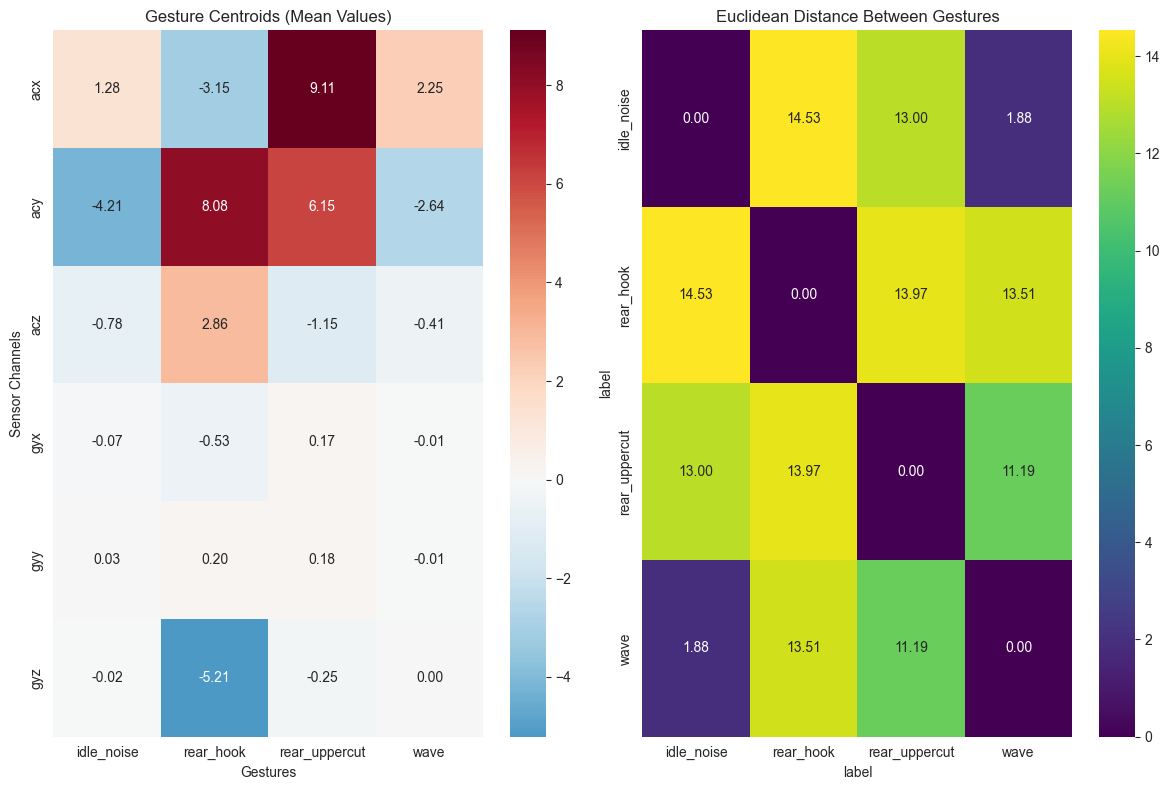

In [28]:
# ====== Gesture Similarity Analysis ======
# Calculate distance matrix between gesture centroids
gesture_means = data.groupby('label')[sensor_cols].mean()

plt.figure(figsize=(12, 8))

# Heatmap of gesture mean values
plt.subplot(1, 2, 1)
sns.heatmap(gesture_means.T, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Gesture Centroids (Mean Values)')
plt.xlabel('Gestures')
plt.ylabel('Sensor Channels')

# Distance matrix between gestures
from scipy.spatial.distance import pdist, squareform
distances = pdist(gesture_means.values, metric='euclidean')
distance_matrix = squareform(distances)
distance_df = pd.DataFrame(distance_matrix, 
                          index=gesture_means.index, 
                          columns=gesture_means.index)

plt.subplot(1, 2, 2)
sns.heatmap(distance_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Euclidean Distance Between Gestures')

plt.tight_layout()
plt.show()


=== FEATURE ENGINEERING PREVIEW ===


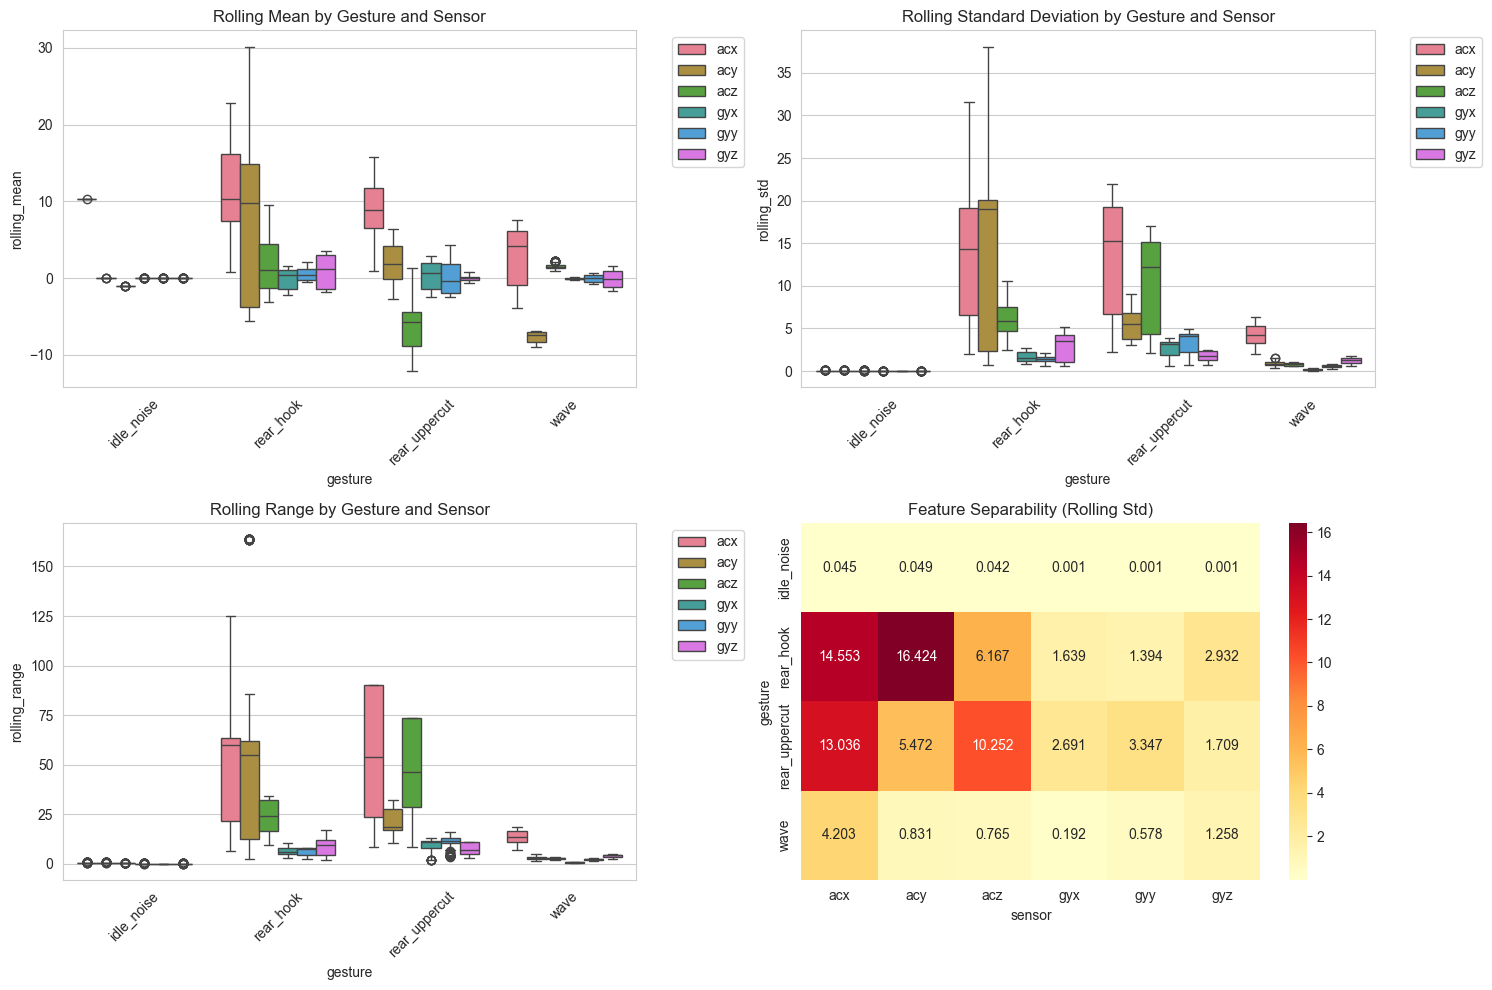

In [29]:
# ====== Feature Engineering Preview ======
# Show what engineered features might look like
print("=== FEATURE ENGINEERING PREVIEW ===")

# Calculate rolling statistics (preview of windowing approach)
window_size = 50
rolling_features = []

for gesture in data['label'].unique():
    gesture_data = data[data['label'] == gesture].head(200)  # Sample for demo
    
    for col in sensor_cols:
        rolling_mean = gesture_data[col].rolling(window=window_size).mean()
        rolling_std = gesture_data[col].rolling(window=window_size).std()
        rolling_min = gesture_data[col].rolling(window=window_size).min()
        rolling_max = gesture_data[col].rolling(window=window_size).max()
        
        feature_data = pd.DataFrame({
            'gesture': gesture,
            'sensor': col,
            'rolling_mean': rolling_mean,
            'rolling_std': rolling_std,
            'rolling_range': rolling_max - rolling_min
        }).dropna()
        
        rolling_features.append(feature_data)

rolling_df = pd.concat(rolling_features, ignore_index=True)

# Visualize engineered features
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=rolling_df, x='gesture', y='rolling_mean', hue='sensor')
plt.title('Rolling Mean by Gesture and Sensor')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 2)
sns.boxplot(data=rolling_df, x='gesture', y='rolling_std', hue='sensor')
plt.title('Rolling Standard Deviation by Gesture and Sensor')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 3)
sns.boxplot(data=rolling_df, x='gesture', y='rolling_range', hue='sensor')
plt.title('Rolling Range by Gesture and Sensor')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 4)
# Show feature separability
feature_separability = rolling_df.groupby(['gesture', 'sensor'])['rolling_std'].mean().unstack()
sns.heatmap(feature_separability, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Feature Separability (Rolling Std)')

plt.tight_layout()
plt.show()

In [30]:
# ====== Summary and Insights ======
print("=== EDA SUMMARY AND INSIGHTS ===")
print(f"✓ Loaded {len(data):,} samples across {data['label'].nunique()} gesture types")
print(f"✓ Data quality: {data.isnull().sum().sum()} missing values detected")
print(f"✓ Gesture balance: {data['label'].value_counts().std():.1f} std deviation in sample counts")

print("\n=== KEY FINDINGS ===")
print("1. Gesture Separability:")
for gesture in data['label'].unique():
    gesture_data = data[data['label'] == gesture]
    unique_signature = f"   {gesture}: avg_acc_mag={gesture_data['acc_magnitude'].mean():.2f}, avg_gyro_mag={gesture_data['gyro_magnitude'].mean():.2f}"
    print(unique_signature)

print("\n2. Data Characteristics:")
print(f"   - Accelerometer range: {data[['acx', 'acy', 'acz']].min().min():.2f} to {data[['acx', 'acy', 'acz']].max().max():.2f}")
print(f"   - Gyroscope range: {data[['gyx', 'gyy', 'gyz']].min().min():.2f} to {data[['gyx', 'gyy', 'gyz']].max().max():.2f}")

print("\n3. Recommended Next Steps:")
print("   - Sequence-based modeling (LSTM/GRU) recommended for temporal patterns")
print("   - Consider data augmentation for underrepresented gestures")
print("   - Feature engineering with rolling statistics shows promise")
print("   - Frequency domain features may help distinguish similar gestures")

=== EDA SUMMARY AND INSIGHTS ===
✓ Loaded 22,124 samples across 4 gesture types
✓ Data quality: 20 missing values detected
✓ Gesture balance: 2699.2 std deviation in sample counts

=== KEY FINDINGS ===
1. Gesture Separability:
   idle_noise: avg_acc_mag=10.03, avg_gyro_mag=0.70
   rear_hook: avg_acc_mag=29.10, avg_gyro_mag=9.42
   rear_uppercut: avg_acc_mag=20.74, avg_gyro_mag=5.55
   wave: avg_acc_mag=11.24, avg_gyro_mag=2.78

2. Data Characteristics:
   - Accelerometer range: -78.45 to 156.90
   - Gyroscope range: -34.87 to 34.87

3. Recommended Next Steps:
   - Sequence-based modeling (LSTM/GRU) recommended for temporal patterns
   - Consider data augmentation for underrepresented gestures
   - Feature engineering with rolling statistics shows promise
   - Frequency domain features may help distinguish similar gestures
